In [1]:
from netwin import *
import os, fnmatch
import matplotlib.pyplot as plt
from nilearn import plotting
import numpy as np
import pandas as pd
import matplotlib as mpl

%load_ext autoreload
%autoreload 2

### Create average ajacency matrix from individual subjects

In [2]:
result =[]
path = '/home/chaggar/Documents/Network_Inference/subjects/'
for root, dirs, files in os.walk(path):
    for name in files:
        if fnmatch.fnmatch(name, 'fdt_network_matrix'):
            result.append(os.path.join(root, name))


In [3]:
A_all = np.ones((83,83,10))
for i, j in enumerate(result):
    A_all[:,:,i] = np.genfromtxt(j)

In [4]:
A = np.mean(A_all,axis=2)

A = A / np.max(A)

SymA = (A + A.T)/np.max(A+A.T)

#### load network model using adjacency matrix

In [5]:
m = NetworkFKPP(A)

p = np.zeros([83]) + 1e-5
mask = [25, 26, 39, 40, 66, 67, 80, 81]
p[mask] = 0.1

k = 5
a = 10

m.t = np.linspace(0,1,100)

u0 = np.append(np.log(p), np.log([k, a]))

sim = m.forward(u0)

### Load coordinates for 83 node connectome

In [6]:
coordinate_path = '/home/chaggar/Documents/Network_Inference/data/mni_coordinates/mni-parcellation-scale1_coordinates.csv'

nodes = pd.read_csv(coordinate_path)

x, y, z = np.array(nodes.x), np.array(nodes.y), np.array(nodes.z)
coords = np.vstack((x, y, z))


In [7]:
alpha = np.linspace(0.7, 1, 258, endpoint=True)
degree_norm = np.diagonal(m.D()) / np.max(m.D())
node_colour = plt.cm.Blues(degree_norm, alpha)


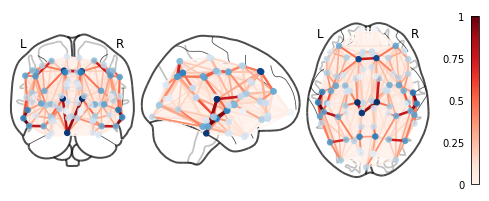

In [8]:
plotting.plot_connectome(node_coords=coords.T,adjacency_matrix=SymA, node_size = 30, colorbar=True, node_color=node_colour, alpha=0.5, edge_cmap='Reds', edge_vmin=0, edge_vmax=1)
plotting.show()

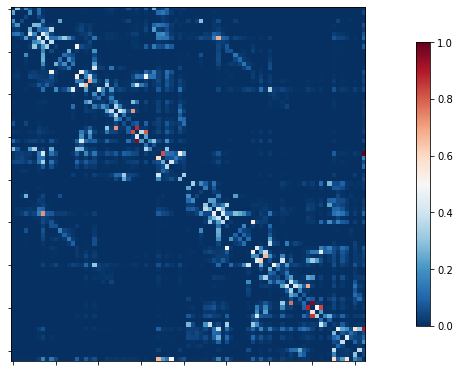

In [9]:
plotting.plot_matrix(A/np.max(A))
plotting.show()

#### plotting forward simulation

In [10]:
alpha = np.linspace(0, 1, 258, endpoint=True)
p_conc = sim[40]/np.max(sim[40])
node_colour = plt.cm.Blues(p_conc, alpha)

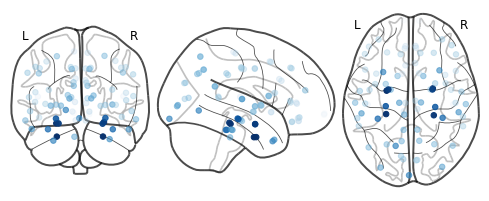

In [11]:
plotting.plot_connectome(node_coords=coords.T,adjacency_matrix=np.eye(83), node_size = 30, node_color=node_colour)
plotting.show()

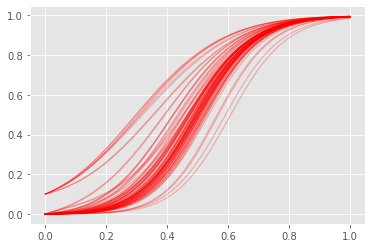

In [38]:
p = np.zeros([83]) + 1e-5
mask = [25, 26, 39, 40, 66, 67, 80, 81]
p[mask] = 0.1

k = 5
a = 10

m.t = np.linspace(0,1,100)

u0 = np.append(np.log(p), np.log([k, a]))

sim = m.forward(u0)

mpl.style.use('ggplot')

ax = plt.figure()

plt.plot(m.t, sim, c='r', alpha=0.3, linewidth=1)
plt.show()

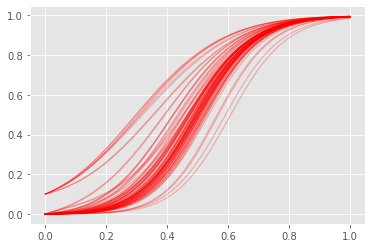

In [30]:
p = np.zeros([83]) + 1e-5
mask = [25, 26, 39, 40, 66, 67, 80, 81]
p[mask] = 0.1

k = 3
a = 10

m.t = np.linspace(0,1,100)

u0 = np.append(np.log(p), np.log([k, a]))

sim = m.forward(u0)

mpl.style.use('ggplot')

ax = plt.figure()

plt.plot(m.t, sim, c='r', alpha=0.3, linewidth=1)
plt.show()

### create noisy data from forward simulation

In [68]:
data = np.empty_like(sim)
for i in range(len(sim[0])):
    data[:,i] = sim[:,i] + (np.random.rand(len(sim[:,i]))/20)

In [11]:
#ax = plt.figure()

#for i in range(len(data[0])):
    #plt.plot(m.t)
#    plt.plot(m.t, data[:,i], c=node_colour[i])

#ax.show()

## Inference

In [19]:
# set priors 
p0 = np.zeros([83])
k0 = 0
a0 = 0
u_0 = np.append(p0, [k0, a0])
n=100

problem = VBProblem(model=m, data=data, init_means=u_0)

sol, F = problem.infer(n=n)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

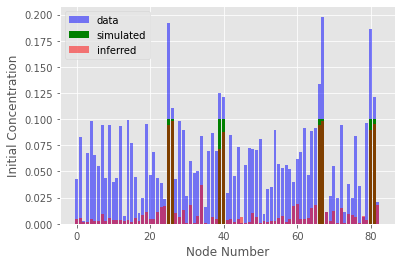

In [21]:
mpl.style.use('ggplot')
plt.bar(range(83), data[0], alpha=0.5, color='b', label='data')
plt.bar(range(83), sim[0], alpha=1, color='g', label='simulated')
plt.bar(range(83), np.exp(sol[0][:-2]), alpha=0.5, color='r', label='inferred')
plt.xlabel("Node Number")
plt.ylabel("Initial Concentration")
plt.legend()
plt.show()

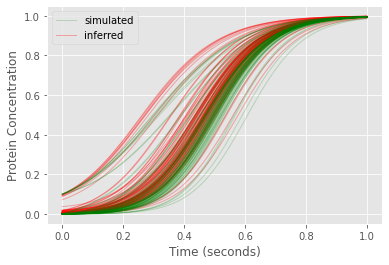

In [22]:
inferred = m.forward(sol[0])
inf = plt.plot(m.t, inferred, c='r', alpha=0.3, linewidth=1, label='inferred')
si = plt.plot(m.t, sim, c='g', alpha=0.2, linewidth=1, label='sim')

plt.ylabel("Protein Concentration")
plt.xlabel("Time (seconds)")
plt.legend((si[0], inf[0]), ('simulated', 'inferred'))

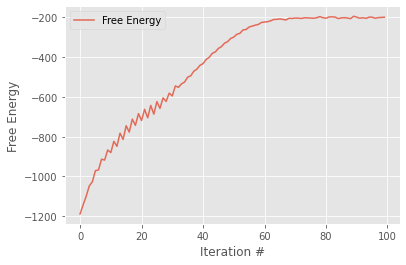

In [20]:
plt.plot(range(n), F, alpha=0.8, label='Free Energy')
plt.ylabel("Free Energy")
plt.xlabel("Iteration #")
plt.legend()
plt.show()

In [28]:
np.exp(sol[0][-2:])

array([2.93666892, 9.93749278])

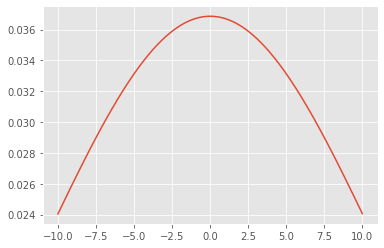

In [55]:
import scipy.stats as stats

cov = np.linalg.inv(sol[1])

mu = np.exp(sol[0][0])
variance = cov[0,0]
sigma = np.sqrt(variance)
x = np.arange(-10, 10, 0.001)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [58]:

import numpy as np
from scipy.special import digamma 
from scipy.special import loggamma 

from scipy.stats import norm, gamma
import matplotlib.pyplot as plt

def plot_posterior(means,cov,labels=None,samples=None,actual=None):
    """
    helper function for plotting posterior distribution
    
    Parameters
    ----------
    means : array like
    cov   : matrix  
    labels : list 
    samples : 2D (samples x params)
              as ouput by MH
    actual : array like
             true parameter values if known

    Returns
    -------
    matplotlib figure
    
    """
    fig = plt.figure(figsize=(10,10))
    n     = means.size
    nbins = 50
    k     = 1
    for i in range(n):
        for j in range(n):
            if i==j:
                x = np.linspace(means[i]-5*np.sqrt(cov[i,i]),
                                means[i]+5*np.sqrt(cov[i,i]),nbins)
                y = norm.pdf(x,means[i],np.sqrt(cov[i,i]))

                plt.subplot(n,n,k)            
                plt.plot(x,y)
                if samples is not None:
                    plt.hist(samples[:,i],histtype='step',density=True)
                if labels is not None:
                    plt.title(labels[i])
                if actual is not None:
                    plt.axvline(x=actual[i],c='r')
                    
            else:
                m = np.asarray([means[i],means[j]])
                v = np.asarray([[cov[i,i],cov[i,j]],[cov[j,i],cov[j,j]]])
                xi = np.linspace(means[i]-5*np.sqrt(cov[i,i]),
                                 means[i]+5*np.sqrt(cov[i,i]),nbins)
                xj = np.linspace(means[j]-5*np.sqrt(cov[j,j]),
                                 means[j]+5*np.sqrt(cov[j,j]),nbins)
                x  = np.asarray([ (a,b) for a in xi for b in xj])
                x  = x-m
                h = np.sum(-.5*(x*(x@np.linalg.inv(v).T)),axis=1)

                h = np.exp(h - h.max())
                h = np.reshape(h,(nbins,nbins))
                plt.subplot(n,n,k)        

                plt.contour(xi,xj,h)
                
                if samples is not None:
                    plt.plot(samples[:,i],samples[:,j],'k.',alpha=.1)
            k=k+1

    plt.show()
    return fig

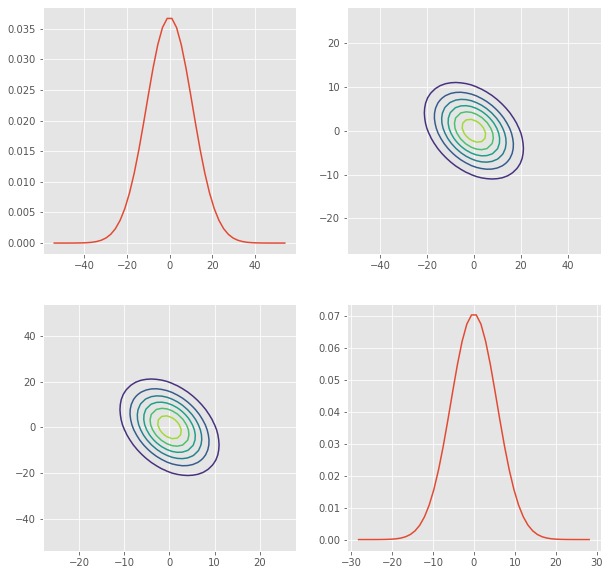

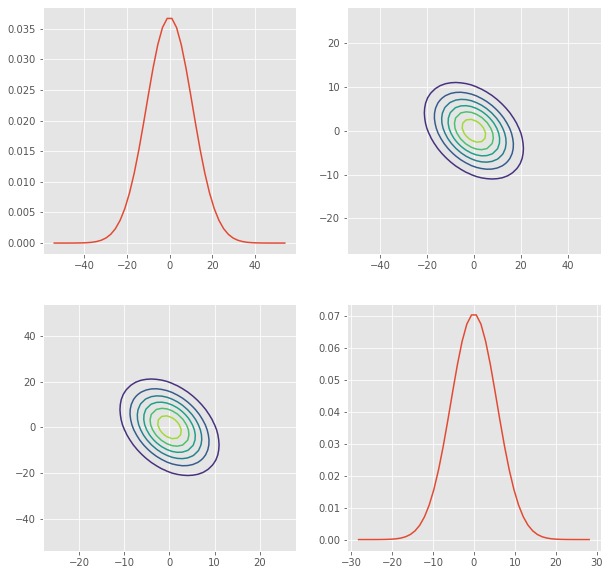

In [66]:
mu = np.exp(sol[0])
cov = np.linalg.inv(sol[1])
plot_posterior(means=mu[:2], cov=cov[:2,:2])